# Travel times and accessibility in Vienna

In this notebook we show the results of the data collection of:

* the location of the nearest POI of some type, starting from the centroid of a given grid cell in Vienna;
* the time required to reach the latter.

The notebook calls wrap functions from the scripts "src/data/download_pois_networks.py" and "src/data/travel_times.py". 

## Imports

In [31]:
import numpy as np
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
import pickle
import os
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statsmodels.api as sm

sys.path.append('../src/data')
from download_pois_networks import download_POIs
from download_pois_networks import download_street_network, networks_to_gdf, analyze_street_network

In [32]:
# Plotting settings
#matplotlib.rcParams.update({'text.usetex': True})
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [33]:
EQUAL_AREA_PROJ = '+proj=cea'
LON_LAT_PROJ = 'EPSG:4326'
MERCATOR_PROJ = 'epsg:3395'

## Utils, the haversine distance function

In [34]:
def haversine(coord1, coord2):
    """
    Calculate the Haversine distance between two points on the Earth.

    Args:
        coord1 (tuple): (longitude, latitude) of the first point in degrees.
        coord2 (tuple): (longitude, latitude) of the second point in degrees.

    Returns:
        float: Distance in kilometers.
    """
    # Radius of the Earth in km
    R = 6371.0  
    
    # Convert degrees to radians
    lon1, lat1 = map(math.radians, coord1)
    lon2, lat2 = map(math.radians, coord2)
    
    # Differences in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine formula
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Compute the distance
    distance = R * c
    
    return distance

## Read data

In [35]:
raw_data_path = '../data/raw/'
os.listdir(raw_data_path)

['ViennaAustria_r8_nearest_loc.pkl',
 'ViennaAustria.pkl',
 'ViennaAustria_r8_hex_grid.pkl',
 'ViennaAustria_networks.pkl',
 'ViennaAustria_r8_travel_times.pkl']

In [36]:
with open(f'{raw_data_path}ViennaAustria_r8_travel_times.pkl','rb') as f:
    gdf_travel_time = pickle.load(f)

with open('../data/raw/ViennaAustria_r8_nearest_loc.pkl','rb') as f:
    gdf_nearest_loc = pickle.load(f)

display(gdf_travel_time.head(5))
display(gdf_nearest_loc.head(5))

geometry         hex_id_x  \
0  POLYGON ((16.50612 48.17424, 16.50206 48.1717,...  885250cebbfffff   
1  POLYGON ((16.52967 48.16208, 16.52561 48.15954...  885250ce89fffff   
2  POLYGON ((16.49395 48.16661, 16.48989 48.16407...  885250ceb7fffff   
3  POLYGON ((16.27151 48.17955, 16.26746 48.17702...  8852504663fffff   
4  POLYGON ((16.30338 48.18162, 16.29932 48.17908...  88525054a7fffff   

   timeto_shop_supermarket         hex_id_y  timeto_amenity_school  \
0                50.181833  885250cebbfffff              78.175000   
1                77.992167  885250ce89fffff             106.188500   
2                30.450333  885250ceb7fffff              72.569000   
3                 7.548833  8852504663fffff              21.048667   
4                 4.790833  88525054a7fffff              14.884167   

   hex_id_existing  timeto_amenity_hospital       hex_id_new  \
0  885250cebbfffff               119.127667  885250cebbfffff   
1  885250ce89fffff               146.938000  885250ce89fffff   
2  885250ceb7fffff                94.259000  885250ceb7fffff   
3  8852504663fffff                82.076500  8852504663fffff   
4  88525054a7fffff                48.090333  88525054a7fffff   

   timeto_leisure_park  
0           122.662167  
1           150.472667  
2            97.793667  
3            70.885500  
4            36.273833

geometry         hex_id_x  \
0  POLYGON ((16.50612 48.17424, 16.50206 48.1717,...  885250cebbfffff   
1  POLYGON ((16.52967 48.16208, 16.52561 48.15954...  885250ce89fffff   
2  POLYGON ((16.49395 48.16661, 16.48989 48.16407...  885250ceb7fffff   
3  POLYGON ((16.27151 48.17955, 16.26746 48.17702...  8852504663fffff   
4  POLYGON ((16.30338 48.18162, 16.29932 48.17908...  88525054a7fffff   

  nearest_shop_supermarket         hex_id_y  nearest_amenity_school  \
0   (16.473657, 48.169685)  885250cebbfffff  (16.477716, 48.219246)   
1   (16.473657, 48.169685)  885250ce89fffff  (16.477716, 48.219246)   
2   (16.473657, 48.169685)  885250ceb7fffff   (16.41914, 48.184465)   
3   (16.270322, 48.177753)  8852504663fffff  (16.262358, 48.192686)   
4   (16.297919, 48.185629)  88525054a7fffff  (16.293336, 48.188819)   

   hex_id_existing nearest_amenity_hospital       hex_id_new  \
0  885250cebbfffff   (16.398451, 48.195704)  885250cebbfffff   
1  885250ce89fffff   (16.398451, 48.195704)  885250ce89fffff   
2  885250ceb7fffff   (16.398451, 48.195704)  885250ceb7fffff   
3  8852504663fffff   (16.345147, 48.192661)  8852504663fffff   
4  88525054a7fffff   (16.345147, 48.192661)  88525054a7fffff   

     nearest_leisure_park  
0  (16.395085, 48.196683)  
1  (16.395085, 48.196683)  
2  (16.395085, 48.196683)  
3     (16.3335, 48.18084)  
4     (16.3335, 48.18084)

In [37]:
gdf_travel_time.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 924 non-null    geometry
 1   hex_id_x                 924 non-null    object  
 2   timeto_shop_supermarket  924 non-null    float64 
 3   hex_id_y                 924 non-null    object  
 4   timeto_amenity_school    924 non-null    float64 
 5   hex_id_existing          924 non-null    object  
 6   timeto_amenity_hospital  924 non-null    float64 
 7   hex_id_new               924 non-null    object  
 8   timeto_leisure_park      924 non-null    float64 
dtypes: float64(4), geometry(1), object(4)
memory usage: 65.1+ KB


In [38]:
gdf_nearest_loc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   geometry                  924 non-null    geometry
 1   hex_id_x                  924 non-null    object  
 2   nearest_shop_supermarket  924 non-null    object  
 3   hex_id_y                  924 non-null    object  
 4   nearest_amenity_school    924 non-null    object  
 5   hex_id_existing           924 non-null    object  
 6   nearest_amenity_hospital  924 non-null    object  
 7   hex_id_new                924 non-null    object  
 8   nearest_leisure_park      924 non-null    object  
dtypes: geometry(1), object(8)
memory usage: 65.1+ KB


In [39]:
na_indices = np.where(gdf_travel_time.isna())[0]
print(na_indices)

[]


## Visualization, travel times

In [40]:
tags={'shop':['supermarket'],'leisure':['park'],'amenity':['school','hospital']}
tag_names = []
for tag_key, tag_values in tags.items():
    for tag_value in tag_values:
        tag_name = f"{tag_key}_{tag_value}"
        tag_names.append(tag_name)
print(tag_names)

['shop_supermarket', 'leisure_park', 'amenity_school', 'amenity_hospital']


228.79333333333335


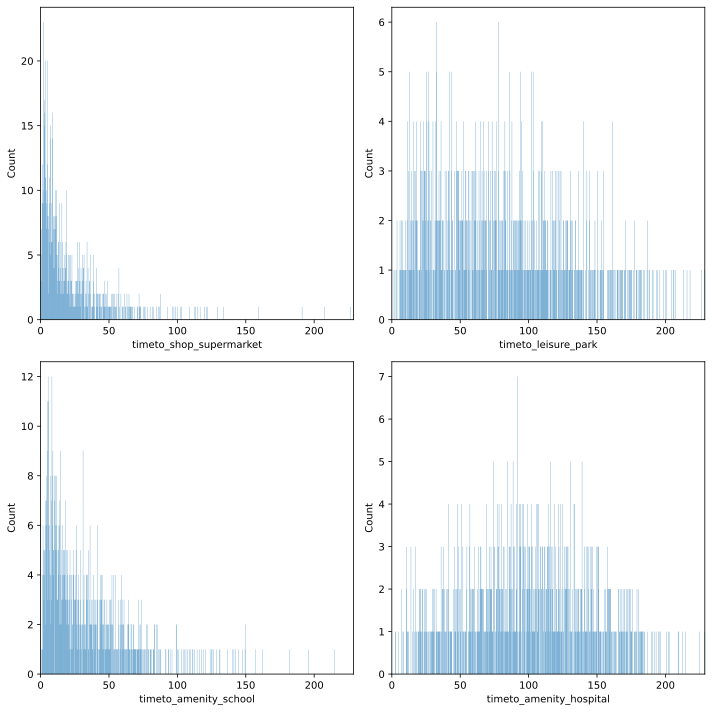

In [45]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
max_value = gdf_travel_time[[f"timeto_{tag_name}" for tag_name in tag_names]].max().max()
print(max_value)
for ax,tag_name in zip(axes.flatten(),tag_names):
    sns.histplot(gdf_travel_time[f"timeto_{tag_name}"],bins=gdf_travel_time.shape[0],ax=ax)
    ax.set_xlim([0,max_value])
fig.tight_layout()
plt.savefig('../reports/figures/travel_times/travel_times_distr.pdf')

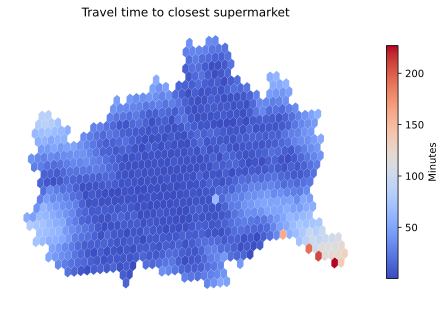

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

gdf_plot = gdf_travel_time.to_crs(MERCATOR_PROJ)
gdf_plot.plot(column='timeto_shop_supermarket',cmap='coolwarm',
              legend=True, legend_kwds={'shrink': 0.7, 'label': 'Minutes'},
              ax=ax)

ax.set_title('Travel time to closest supermarket')
ax.set_axis_off()
plt.savefig('../reports/figures/travel_times/timeto_shop_supermarket.pdf')

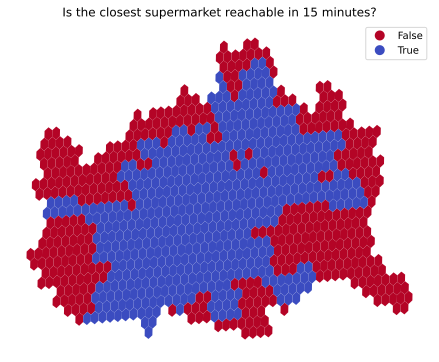

In [30]:
fig, ax = plt.subplots(figsize=(8,6))

gdf_plot = gdf_travel_time.to_crs(MERCATOR_PROJ)
gdf_plot['<15_min'] = gdf_travel_time['timeto_shop_supermarket']<15
gdf_plot.plot(column='<15_min',legend=True,cmap='coolwarm_r',ax=ax)

ax.set_title('Is the closest supermarket reachable in 15 minutes?')
ax.set_axis_off()
plt.savefig('../reports/figures/travel_times/15min_shop_supermarket.pdf')

228.79333333333335


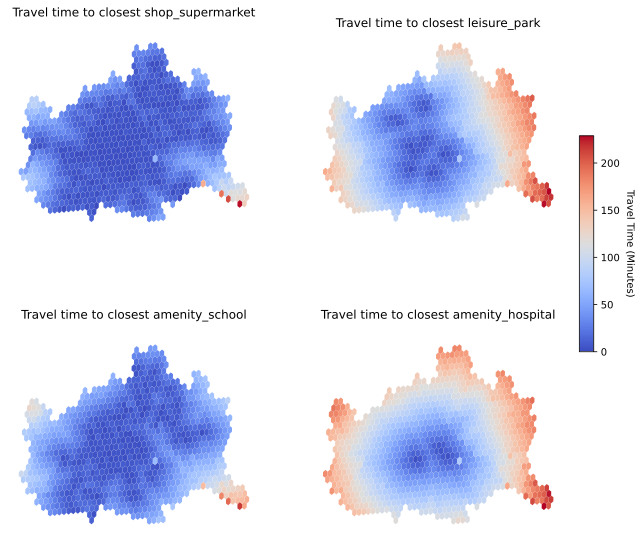

In [56]:
fig,axes = plt.subplots(2,2,figsize=(10,10))

# Compute max value
max_value = gdf_travel_time[[f"timeto_{tag_name}" for tag_name in tag_names]].max().max()
print(max_value)

# Prepare gdf
gdf_plot = gdf_travel_time.to_crs(MERCATOR_PROJ)

# Colormap
cmap = plt.cm.coolwarm
norm = plt.Normalize(0, max_value)

# Iterate
for ax,tag_name in zip(axes.flatten(),tag_names):
    gdf_plot.plot(column=f'timeto_{tag_name}',cmap=cmap, norm=norm,ax=ax)
    ax.set_title(f'Travel time to closest {tag_name}')
    ax.set_axis_off()

# Draw colormap
plt.subplots_adjust(right=0.9) 
cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.3])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
fig.colorbar(sm, cax=cbar_ax,shrink=0.5)
cbar_ax.set_ylabel('Travel Time (Minutes)', rotation=270, labelpad=15)

#fig.tight_layout()
plt.savefig(f'../reports/figures/travel_times/timeto_{'|'.join(tag_names)}.pdf')

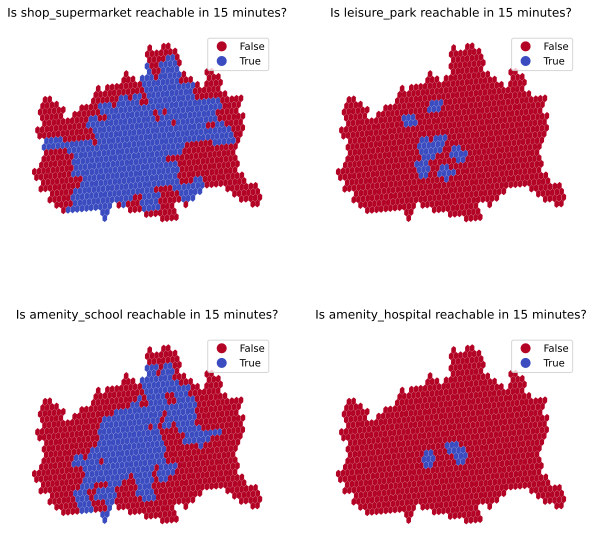

In [60]:
fig,axes = plt.subplots(2,2,figsize=(10,10))

# Prepare gdf
gdf_plot = gdf_travel_time.to_crs(MERCATOR_PROJ)
for tag_name in tag_names:
    gdf_plot[f'<15_min_{tag_name}'] = gdf_travel_time[f'timeto_{tag_name}']<15

# Iterate
for ax,tag_name in zip(axes.flatten(),tag_names):
    gdf_plot.plot(column=f'<15_min_{tag_name}',cmap='coolwarm_r',ax=ax,legend=True)
    ax.set_title(f'Is {tag_name} reachable in 15 minutes?')
    ax.set_axis_off()

#fig.tight_layout()
plt.savefig(f'../reports/figures/travel_times/15min_{'|'.join(tag_names)}.pdf')

## Closest POIs

/tmp/ipykernel_9041/2184621582.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_nearest_loc_plot['centroid'] = gdf_nearest_loc_plot['geometry'].centroid


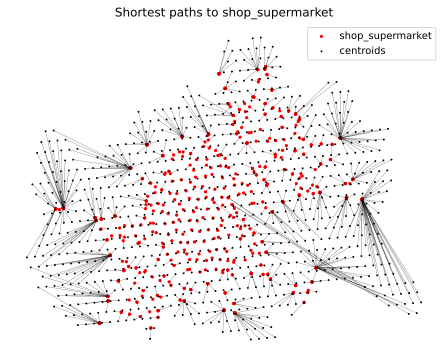

In [78]:
# Prepare gdf
gdf_nearest_loc_plot = gdf_nearest_loc.copy()
gdf_nearest_loc_plot['centroid'] = gdf_nearest_loc_plot['geometry'].centroid 
for tag_name in tag_names:  
    gdf_nearest_loc_plot[f'nearest_{tag_name}'] = gdf_nearest_loc_plot[f'nearest_{tag_name}'].apply(lambda x: Point(x)) 

# Specify tag name
tag_name = 'shop_supermarket'

# Plot centroids and nearest locations
fig, ax = plt.subplots(figsize=(8,6))
gdf_nearest_loc_plot = gdf_nearest_loc_plot.to_crs(MERCATOR_PROJ)
gdf_nearest_loc_plot.set_geometry(f'nearest_{tag_name}').plot(ax=ax, color='r', alpha=1, markersize=5, label=f'{tag_name}')
gdf_nearest_loc_plot.set_geometry('centroid').plot(ax=ax, color='k', markersize=1, label='centroids')
ax.legend()

# Drawa line connecting centroids and nearest locations
for idx, row in gdf_nearest_loc_plot.iterrows():
    ax.plot([row['centroid'].x, row[f'nearest_{tag_name}'].x], [row['centroid'].y, row[f'nearest_{tag_name}'].y], 'k',lw=0.2) 

ax.set_axis_off()
ax.set_title(f'Shortest paths to {tag_name}') 
plt.savefig(f'../reports/figures/travel_times/shortest_paths_{tag_name}.pdf')   

/tmp/ipykernel_9041/1494901369.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_nearest_loc_plot['centroid'] = gdf_nearest_loc_plot['geometry'].centroid


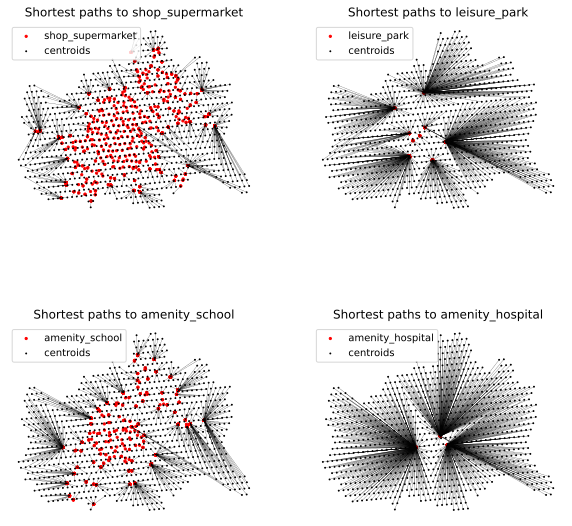

In [82]:
# Prepare gdf
gdf_nearest_loc_plot = gdf_nearest_loc.copy()
gdf_nearest_loc_plot['centroid'] = gdf_nearest_loc_plot['geometry'].centroid 
for tag_name in tag_names:  
    gdf_nearest_loc_plot[f'nearest_{tag_name}'] = gdf_nearest_loc_plot[f'nearest_{tag_name}'].apply(lambda x: Point(x)) 

# Figure
fig, axes = plt.subplots(2,2,figsize=(10,10))
gdf_nearest_loc_plot = gdf_nearest_loc_plot.to_crs(MERCATOR_PROJ)

# Iterate over tag names
for ax,tag_name in zip(axes.flatten(),tag_names):

    # Plot centroids and nearest locations
    gdf_nearest_loc_plot.set_geometry(f'nearest_{tag_name}').plot(ax=ax, color='r', alpha=1, markersize=5, label=f'{tag_name}')
    gdf_nearest_loc_plot.set_geometry('centroid').plot(ax=ax, color='k', markersize=1, label='centroids')
    ax.legend()

    # Drawa line connecting centroids and nearest locations
    for idx, row in gdf_nearest_loc_plot.iterrows():
        ax.plot([row['centroid'].x, row[f'nearest_{tag_name}'].x], [row['centroid'].y, row[f'nearest_{tag_name}'].y], 'k',lw=0.2) 

    ax.set_axis_off()
    ax.set_title(f'Shortest paths to {tag_name}') 
plt.savefig(f'../reports/figures/travel_times/shortest_paths_{'|'.join(tag_names)}.pdf')   

## Travel times and distance

In [14]:
# Haversine distance between a centroid and an amenity
cen = gdf_nearest_loc.geometry.iloc[0].centroid
cen = (cen.x,cen.y)
ame = gdf_nearest_loc.nearest_shop_supermarket.iloc[0]
print(cen)
print(ame)
print(haversine(cen,ame))

(16.502193097460083, 48.17626363340371)
(16.473657, 48.169685)
2.238940971073067


In [15]:
# Merge
gdf_time_and_distance = pd.merge(gdf_travel_time,gdf_nearest_loc,on='geometry')

# Haversine
gdf_time_and_distance['distanceto_shop_supermarket'] = gdf_time_and_distance.apply(
    lambda row: haversine((row['geometry'].centroid.x,row['geometry'].centroid.y),row['nearest_shop_supermarket']),axis=1)

display(gdf_time_and_distance.head(1))

geometry         hex_id_x  \
0  POLYGON ((16.50612 48.17424, 16.50206 48.1717,...  885250cebbfffff   

   timeto_shop_supermarket         hex_id_y nearest_shop_supermarket  \
0                50.181833  885250cebbfffff   (16.473657, 48.169685)   

   distanceto_shop_supermarket  
0                     2.238941

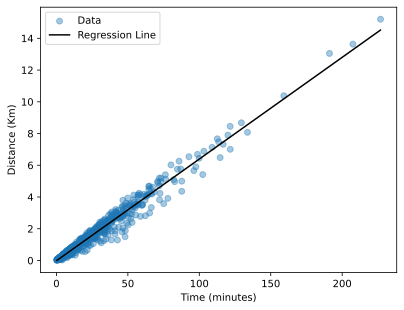

                                 OLS Regression Results                                
Dep. Variable:     distanceto_shop_supermarket   R-squared:                       0.974
Model:                                     OLS   Adj. R-squared:                  0.974
Method:                          Least Squares   F-statistic:                 3.440e+04
Date:                         Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                                 11:25:30   Log-Likelihood:                -64.582
No. Observations:                          924   AIC:                             133.2
Df Residuals:                              922   BIC:                             142.8
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [28]:
# Get data
X = gdf_time_and_distance['timeto_shop_supermarket']
X = sm.add_constant(X)
y = gdf_time_and_distance['distanceto_shop_supermarket']

# Linear regresion
model = sm.OLS(y, X).fit()

# Predict
predicted_y = model.predict(X)

# Plot
fig, ax = plt.subplots()
ax.scatter(gdf_time_and_distance['timeto_shop_supermarket'],gdf_time_and_distance['distanceto_shop_supermarket'], alpha=0.4, label='Data')

# Plot regression line
ax.plot(gdf_time_and_distance['timeto_shop_supermarket'], predicted_y, color='k', label='Regression Line')

# Labels and legend
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Distance (Km)')
ax.legend()

plt.savefig('../reports/figures/travel_times/regression_time_distance.pdf')
plt.show()

print(model.summary())

In [26]:
# get coefficient
coef_ = model.params['timeto_shop_supermarket']
print(coef_)

0.064091320251355


In [27]:
# This correponds to
print('Avg speed:', coef_*60, "km/h", ", typical walking speed ~ 5 km/h")
# Reasonable slowing down due to graph-based distance

Avg speed: 3.8454792150813 km/h , typical walking speed ~ 5 km/h
